<a href="https://colab.research.google.com/github/shahriar1990/-Applied-Data-Science-Capstone-Week-4/blob/main/%7C%D9%BE%D8%B1%D9%88%DA%98%D9%87_%D8%AA%D8%B1%D8%AC%D9%85%D9%87_%D9%85%D8%A7%D8%B4%DB%8C%D9%86%DB%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,RepeatVector
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
import tensorflow as tf

In [2]:
df = pd.read_csv('/content/pes.txt' , delimiter="\t" , names = ['english' , 'persian' ,'ignore'])
del df['ignore']
df.head(10)


,english,persian
0,Who?,چه کسی؟
1,Go on.,ادامه بده ( ادامه دادن )
2,Smile.,لبخند بزن.
3,Attack!,حمله!
4,Got it!,گرفتم!
5,I know.,من می دانم.
6,Listen.,گوش کن.
7,Really?,واقعا؟
8,Really?,جدا؟
9,Why me?,چرا من؟


In [3]:
df.isna().sum() # Checking for nan Values


english    0
persian    0
dtype: int64

In [4]:
punctuation = list(string.punctuation)
punctuation[:5]

['!', '"', '#', '$', '%']

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Removing html text
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)
# Removing punctuations, non-alphabetical characters & converting text to lowercase
def clean_text(text):
    final_text = []
    for i in word_tokenize(text):
        if i.strip().lower().isalpha() and i.strip().lower() not in punctuation:
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = clean_text(text)
    return text
#Apply function on text columns
df['english']=df['english'].apply(denoise_text)
df['persian']=df['persian'].apply(denoise_text)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [7]:
df.drop_duplicates(inplace = True)
df.head(10)

,english,persian
0,who,چه
1,go on,ادامه بده ادامه دادن
2,smile,لبخند بزن
3,attack,حمله
4,got it,گرفتم
5,i know,من می دانم
6,listen,گوش کن
7,really,
9,why me,چرا
10,be cool,راحت باش


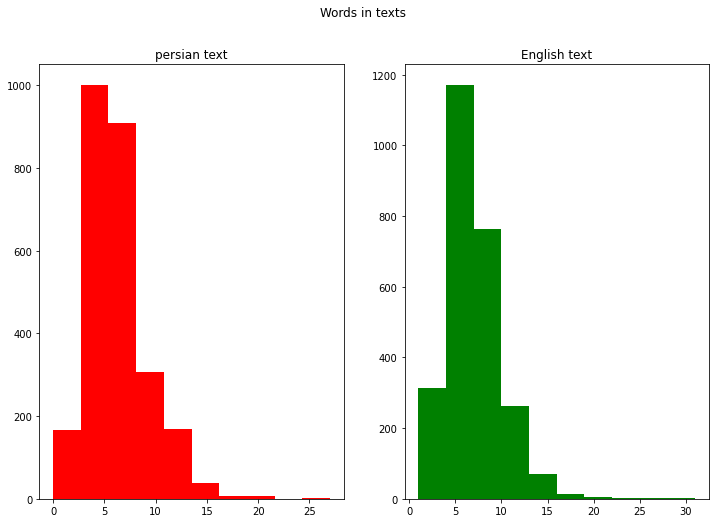

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df['persian'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('persian text')
text_len=df['english'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('English text')
fig.suptitle('Words in texts')
plt.show()

In [9]:
per_max,en_max = 0,0
for i in df['persian'].str.split().values:
    if(len(i) > per_max):
        per_max = len(i)
for i in df['english'].str.split().values:
    if(len(i) > en_max):
        en_max = len(i)
print(per_max,en_max) 

27 31


In [10]:
x_train,x_test,y_train,y_test = train_test_split(df.persian.values , df.english.values , test_size = 0.1 , random_state = 0)


In [11]:
len(x_train),len(x_test)


(2344, 261)

In [12]:
per_tokenizer = text.Tokenizer()
per_tokenizer.fit_on_texts(x_train)
per_tokenized_train = per_tokenizer.texts_to_sequences(x_train)
X_train = sequence.pad_sequences(per_tokenized_train, maxlen = per_max , padding = 'post')

per_tokenized_test = per_tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(per_tokenized_test, maxlen = per_max , padding = 'post')

In [13]:
en_tokenizer = text.Tokenizer()
en_tokenizer.fit_on_texts(y_train)
en_tokenized_train = en_tokenizer.texts_to_sequences(y_train)
Y_train = sequence.pad_sequences(en_tokenized_train, maxlen = en_max , padding = 'post')

en_tokenized_test = en_tokenizer.texts_to_sequences(y_test)
Y_test = sequence.pad_sequences(en_tokenized_test, maxlen = en_max , padding = 'post')

In [19]:
eng_vocab_size = len(en_tokenizer.word_index) + 1
per_vocab_size = len(per_tokenizer.word_index) + 1
print(eng_vocab_size)
print(fr_vocab_size)

2482
3134


In [20]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.112.130.2:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.112.130.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.112.130.2:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [22]:
with strategy.scope():
    # Encoder
    model = Sequential()
    model.add(Embedding(per_vocab_size, output_dim = 512, input_length = per_max , mask_zero = True))
    model.add(Bidirectional(LSTM(units = 256 , return_sequences=True , recurrent_dropout = 0.25 , dropout = 0.25)))
    model.add(LSTM(units = 64 , recurrent_dropout = 0.1 , dropout = 0.1))
    model.add(RepeatVector(en_max))
    # Decoder
    model.add(LSTM(units = 64 , return_sequences=True , recurrent_dropout = 0.1 , dropout = 0.1))
    model.add(Bidirectional(LSTM(units = 256, return_sequences=True , recurrent_dropout = 0.25 , dropout = 0.25)))
    model.add(Dense(eng_vocab_size, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 512)           1604608   
                                                                 
 bidirectional (Bidirectiona  (None, 27, 512)          1574912   
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64)                147712    


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                 
 repeat_vector (RepeatVector  (None, 31, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 31, 64)            33024     
                                                                 
 bidirectional_1 (Bidirectio  (None, 31, 512)          657408    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 31, 2482)          1273266   
                                                                 
Total params: 5,290,930
Trainable params: 5,290,930
Non-trainable params: 0
_________________________________________________________________


In [24]:
lr_callback = ReduceLROnPlateau(monitor = 'val_loss' , factor = 0.5 , patience = 3 , min_lr = 0.0000001)
checkpoint = ModelCheckpoint('best_model.h5', monitor = 'val_loss' , save_best_only = True)
history = model.fit(X_train, Y_train, epochs=30, batch_size=512, validation_data = (X_test,Y_test) , callbacks = [lr_callback,checkpoint])


Epoch 1/30


InternalError: ignored

In [ ]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
import gc
gc.collect();

In [ ]:
from tqdm import tqdm
final_predictions = []
for i in tqdm(range(0,len(X_test),400)):
    try:
        p = model.predict_classes(X_test[i:i+400])[:400]
        final_predictions.extend(p)
    except:    
        p = model.predict_classes(X_test[i:i+400])
        final_predictions.extend(p)

In [ ]:
final_predictions = final_predictions[:17201]
len(final_predictions)

In [ ]:
def get_word(n, tokenizer):
    words = list(tokenizer.word_index.keys())
    try:
        return words[n-1]
    except:
        return None
    '''for word, index in tokenizer.word_index.items():
        if index == n:
            return word'''

In [ ]:
preds_text = []
for i in tqdm(final_predictions):
    temp = []
    for j in range(len(i)):
        if(i[j] == 0):
            break
        t = get_word(i[j], en_tokenizer)
        if j > 0: #If it is not the first word
            if (t == get_word(i[j-1], en_tokenizer)) or (t == None):  #if the next word is same as the previous
                temp.append('')
            else:
                temp.append(t)
             
        else: #if it's not the first word
            if(t == None): #if we didn't get a valid code from dictionary 
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
len(preds_text)

In [ ]:
pred_df = pd.DataFrame({'actual' : y_test, 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.tail(10)

In [ ]:
bleu_scores = []
for i in pred_df.values:
    BLEUscore = nltk.translate.bleu([i[0].split()], i[1].split())
    bleu_scores.append(BLEUscore)

In [ ]:
bleu_scores = np.array(bleu_scores , dtype = float)
bleu_scores.max(),bleu_scores.min(),bleu_scores.mean()

In [ ]:
pred_df['BLEU_SCORE'] = bleu_scores
pred_df.tail(10)